<a href="https://colab.research.google.com/github/phoumithona/matrix_computation/blob/master/Assignment_10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import matplotlib.pyplot as plt
import numpy as np

file_data   = "mnist.csv"
handle_file = open(file_data, "r")
data        = handle_file.readlines()
handle_file.close()

size_row    = 28    # height of the image
size_col    = 28    # width of the image

num_image   = len(data)
count       = 0     # count for the number of images

# normalize the values of the input data to be [0, 1]
def normalize(data):
    data_normalized = (data - min(data)) / (max(data) - min(data))
    return(data_normalized)

# make a matrix each column of which represents an images in a vector form
list_image  = np.empty((size_row * size_col, num_image), dtype=float)
list_label  = np.empty(num_image, dtype=int)

for line in data:
    line_data   = line.split(',')
    label       = line_data[0]
    im_vector   = np.asfarray(line_data[1:])
    im_vector   = normalize(im_vector)

    list_label[count]     = label
    list_image[:, count]  = im_vector

    count += 1

# split dataset
x_train = list_image[:,:1000] # 6000 rows training image
y_train = list_label[:1000,]  # 6000 rows training label
x_test  = list_image[:,1000:] # 4000 rows testing image
y_test  = list_label[1000:,]  # 4000 rows testing label

# data transpose
x_train = x_train.T
y_train = y_train
x_test  = x_test.T
y_test  = y_test

In [0]:
import time
import copy

#
# build our neural network model
#
class NN:
    first_layer = {}
    second_layer = {}

    def __init__(self, inputs, hidden, outputs):
        # initialize the model parameters, including the first and second layer 
        # parameters and biases
        self.first_layer['para'] = np.random.randn(hidden,inputs) / np.sqrt(num_inputs)
        self.first_layer['bias'] = np.random.randn(hidden,1) / np.sqrt(hidden)
        self.second_layer['para'] = np.random.randn(outputs,hidden) / np.sqrt(hidden)
        self.second_layer['bias'] = np.random.randn(outputs,1) / np.sqrt(hidden)
        self.input_size = inputs
        self.hid_size = hidden
        self.output_size = outputs

    def __activfunc(self, Z, type = 'sigmoid', deri = False):
        # implement the activation function
        if type == 'sigmoid':
            if deri == True:
                return 1/(1 + np.exp(-Z))*(1-1/(1 + np.exp(-Z)))
            else:
                return 1/(1 + np.exp(-Z))
        else:
            raise TypeError('Invalid type!')

    def __cross_entropy_error(self,v,y):
        # implement the cross entropy error
        return -np.log(v[y])

    def __forward(self,x,y):
        # implement the forward computation, calculation of prediction list and error
        Z = np.matmul(self.first_layer['para'],x).reshape((self.hid_size,1)) + self.first_layer['bias']
        H = np.array(self.__activfunc(Z)).reshape((self.hid_size,1))
        U = np.matmul(self.second_layer['para'],H).reshape((self.output_size,1)) + self.second_layer['bias']
        predict_list = np.squeeze(self.__activfunc(U))
        error = self.__cross_entropy_error(predict_list,y)
        
        dic = {
            'Z':Z,
            'H':H,
            'U':U,
            'f_X':predict_list.reshape((1,self.output_size)),
            'error':error
        }
        return dic

    def __back_propagation(self,x,y,f_result):
        # implement the back propagation process, compute the gradients
        E = np.array([0]*self.output_size).reshape((1,self.output_size))
        E[0][y] = 1
        dU = (-(E - f_result['f_X'])).reshape((self.output_size,1))
        db_2 = copy.copy(dU)
        dC = np.matmul(dU,f_result['H'].transpose())
        delta = np.matmul(self.second_layer['para'].transpose(),dU)
        db_1 = delta.reshape(self.hid_size,1)*self.__activfunc(f_result['Z'], 
                                                               deri=True).reshape(self.hid_size,1)
        dW = np.matmul(db_1.reshape((self.hid_size,1)),x.reshape((1,784)))

        grad = {
            'dC':dC,
            'db_2':db_2,
            'db_1':db_1,
            'dW':dW
        }
        return grad

    def __optimize(self,b_result, learning_rate):
        # update the hyperparameters
        self.second_layer['para'] -= learning_rate*b_result['dC']
        self.second_layer['bias'] -= learning_rate*b_result['db_2']
        self.first_layer['bias'] -= learning_rate*b_result['db_1']
        self.first_layer['para'] -= learning_rate*b_result['dW']

    def __loss(self,X_train,Y_train):
        # implement the loss function of the training set
        loss = 0
        for n in range(len(X_train)):
            y = Y_train[n]
            x = X_train[n][:]
            loss += self.__forward(x,y)['error']
        return loss

    def train(self, X_train, Y_train, num_iterations = 1000, learning_rate = 0.5):
        # generate a random list of indices for the training set
        rand_indices = np.random.choice(len(X_train), num_iterations, replace=True)
        
        def l_rate(base_rate, ite, num_iterations, schedule = False):
        # determine whether to use the learning schedule
            if schedule == True:
                return base_rate * 10 ** (-np.floor(ite/num_iterations*5))
            else:
                return base_rate

        count = 1
        loss_dict = {}
        test_dict = {}

        for i in rand_indices:
            f_result = self.__forward(X_train[i],Y_train[i])
            b_result = self.__back_propagation(X_train[i],Y_train[i],f_result)
            self.__optimize(b_result,l_rate(learning_rate,i,num_iterations,True))
            
            if count % 1000 == 0:
                if count % 5000 == 0:
                    loss = self.__loss(X_train,Y_train)
                    test = self.testing(x_test,y_test)
                    print('Trained for {} times,'.format(count),
                          'Training Loss = {}, Accuarcy Test: = {}'.format(loss, test))
                    loss_dict[str(count)] = loss
                    test_dict[str(count)] = test
                else:
                    print('Trained for {} times,'.format(count))
            count += 1

        print('Training finished!')
        return loss_dict, test_dict

    def testing(self,X_test, Y_test):
        # test the model on the training dataset
        total_correct = 0
        for n in range(len(X_test)):
            y = Y_test[n]
            x = X_test[n][:]
            prediction = np.argmax(self.__forward(x,y)['f_X'])
            if (prediction == y):
                total_correct += 1
        #print('Accuarcy Test: ',total_correct/len(X_test))
        return total_correct/np.float(len(X_test))

In [6]:
#
# train and test our model
#

# set the number of iterations
num_iterations = 100000
# set the base learning rate
learning_rate = 0.001
# number of inputs
num_inputs = 28*28
# number of outputs
num_outputs = 10
# size of hidden layer
hidden_size = 200

# data fitting, training and accuracy evaluation
model = NN(num_inputs,hidden_size,num_outputs)
cost_dict, tests_dict = model.train(x_train, y_train, num_iterations = num_iterations,
                                    learning_rate=learning_rate)
accu = model.testing(x_test,y_test)

Trained for 1000 times,
Trained for 2000 times,
Trained for 3000 times,
Trained for 4000 times,
Trained for 5000 times, Training Loss = 1925.5774271194277, Accuarcy Test: = 0.5318888888888889
Trained for 6000 times,
Trained for 7000 times,
Trained for 8000 times,
Trained for 9000 times,
Trained for 10000 times, Training Loss = 1531.016611649777, Accuarcy Test: = 0.6524444444444445
Trained for 11000 times,
Trained for 12000 times,
Trained for 13000 times,
Trained for 14000 times,
Trained for 15000 times, Training Loss = 1250.3994918091566, Accuarcy Test: = 0.7331111111111112
Trained for 16000 times,
Trained for 17000 times,
Trained for 18000 times,
Trained for 19000 times,
Trained for 20000 times, Training Loss = 1017.2490504527559, Accuarcy Test: = 0.757
Trained for 21000 times,
Trained for 22000 times,
Trained for 23000 times,
Trained for 24000 times,
Trained for 25000 times, Training Loss = 904.9610849053166, Accuarcy Test: = 0.7906666666666666
Trained for 26000 times,
Trained for 27

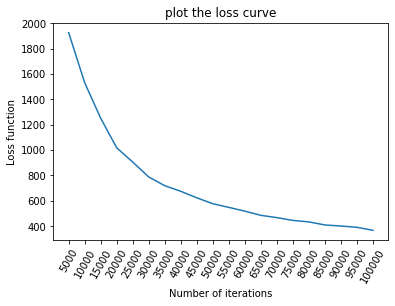

In [7]:
# plotting the loss Curve
import matplotlib.pyplot as plt
plt.plot(list(cost_dict.keys()), list(cost_dict.values()))
plt.ylabel('Loss function')
plt.xlabel('Number of iterations')
plt.xticks(rotation=60)
plt.title('plot the loss curve')
plt.show()